In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import os
import random
import re
from nltk.sentiment import SentimentIntensityAnalyzer
import datetime
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\amoueye\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import utils
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amoueye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amoueye\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
df= pd.read_csv('../Data/sentiment_data_cleaned.csv')

In [6]:
df.head()

,Unnamed: 0,date,adj_close,volume,ticker,1_day_return,TWEET
0,0,2017-01-31,28.308922,196804000,AAPL,-0.002307,Apple will break losing streak this quarter: P...
1,1,2017-01-31,28.308922,196804000,AAPL,-0.002307,"Apple iPad Air 2 128GB, Wi-Fi, 9.7in - Space G..."
2,2,2017-01-31,28.308922,196804000,AAPL,-0.002307,"Apple iPad Air 2 128GB, Wi-Fi, 9.7in - Space G..."
3,3,2017-01-31,28.308922,196804000,AAPL,-0.002307,"Apple iPad Air 2 128GB, Wi-Fi, 9.7in - Space G..."
4,4,2017-01-31,28.308922,196804000,AAPL,-0.002307,"Apple iPad Air 2 128GB, Wi-Fi, 9.7in - Space G..."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206724 entries, 0 to 206723
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    206724 non-null  int64  
 1   date          206724 non-null  object 
 2   adj_close     206724 non-null  float64
 3   volume        206724 non-null  int64  
 4   ticker        206724 non-null  object 
 5   1_day_return  206724 non-null  float64
 6   TWEET         206724 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


In [8]:
df.drop(columns='Unnamed: 0', inplace=True)

In [9]:
df['date'] =  pd.to_datetime(df['date'])


In [10]:
df['date'].min() , df['date'].max()

(Timestamp('2017-01-31 00:00:00'), Timestamp('2018-10-30 00:00:00'))

In [11]:
df.shape

(206724, 6)

### Preprocess All the Twits

In [12]:


def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    # Remove special characters and punctuation
    text = re.sub(r"[^\w\s]", "", text)
    # Remove numbers
    text = re.sub(r"\d+", "", text)
    #Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub(r'[$][a-zA-Z]+', ' ', text)
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub(r'[@][a-zA-Z]+', ' ', text)
    # Replace everything not a letter with a space
    text = re.sub(r'[^a-zA-Z]', ' ', text) # pass
    
    tokens =  text.split() 
    
    # Remove stop words
    text= ' '.join([word for word in tokens if word not in (stop_words)])

    return text


In [13]:
# Lemmatize words using the WordNetLemmatizer

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st

Now we can preprocess each of the twits in our dataset. Apply the function preprocess_text to all the twit messages.

In [14]:
# create a new column that includes the preprocessed tweets

df['processed_text'] = df['TWEET'].apply(preprocess_text)

df['processed_text'] = df['processed_text'].apply(lemmatize_text)

In [15]:
df.head()

,date,adj_close,volume,ticker,1_day_return,TWEET,processed_text
0,2017-01-31,28.308922,196804000,AAPL,-0.002307,Apple will break losing streak this quarter: P...,apple break losing streak quarter pro nehal ch...
1,2017-01-31,28.308922,196804000,AAPL,-0.002307,"Apple iPad Air 2 128GB, Wi-Fi, 9.7in - Space G...",apple ipad air gb wifi space gray latest model
2,2017-01-31,28.308922,196804000,AAPL,-0.002307,"Apple iPad Air 2 128GB, Wi-Fi, 9.7in - Space G...",apple ipad air gb wifi space gray latest model
3,2017-01-31,28.308922,196804000,AAPL,-0.002307,"Apple iPad Air 2 128GB, Wi-Fi, 9.7in - Space G...",apple ipad air gb wifi space gray latest model
4,2017-01-31,28.308922,196804000,AAPL,-0.002307,"Apple iPad Air 2 128GB, Wi-Fi, 9.7in - Space G...",apple ipad air gb wifi space gray latest model


In [16]:
df.drop(columns= 'TWEET', inplace=True)

In [17]:
df.drop_duplicates(keep='first', inplace=True)

In [18]:
df.head()

,date,adj_close,volume,ticker,1_day_return,processed_text
0,2017-01-31,28.308922,196804000,AAPL,-0.002307,apple break losing streak quarter pro nehal ch...
1,2017-01-31,28.308922,196804000,AAPL,-0.002307,apple ipad air gb wifi space gray latest model
5,2017-01-31,28.308922,196804000,AAPL,-0.002307,alien project apple music spotify tidal etc pe...
6,2017-01-31,28.308922,196804000,AAPL,-0.002307,apple iphone gb black unlocked smartphone case...
8,2017-01-31,28.308922,196804000,AAPL,-0.002307,finally stream prince music spotify apple musi...


In [19]:
df=df.reset_index()
df.drop(columns='index', inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124244 entries, 0 to 124243
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            124244 non-null  datetime64[ns]
 1   adj_close       124244 non-null  float64       
 2   volume          124244 non-null  int64         
 3   ticker          124244 non-null  object        
 4   1_day_return    124244 non-null  float64       
 5   processed_text  124244 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 5.7+ MB


In [21]:
# Preprocess the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['processed_text'])
sequences = tokenizer.texts_to_sequences(df['processed_text'])
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [22]:
padded_sequences.shape

(124244, 26)

In [23]:
sia = SentimentIntensityAnalyzer()

# Function to get sentiment label using VADER sentiment analysis
def get_sentiment_label(tweet):
    sentiment_scores = sia.polarity_scores(tweet)
    compound_score = sentiment_scores['compound']
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [24]:
# Prepare the labels 
df['labels'] = df['processed_text'].apply(lambda x: get_sentiment_label(x))

In [25]:
df.head()

,date,adj_close,volume,ticker,1_day_return,processed_text,labels
0,2017-01-31,28.308922,196804000,AAPL,-0.002307,apple break losing streak quarter pro nehal ch...,negative
1,2017-01-31,28.308922,196804000,AAPL,-0.002307,apple ipad air gb wifi space gray latest model,neutral
2,2017-01-31,28.308922,196804000,AAPL,-0.002307,alien project apple music spotify tidal etc pe...,neutral
3,2017-01-31,28.308922,196804000,AAPL,-0.002307,apple iphone gb black unlocked smartphone case...,positive
4,2017-01-31,28.308922,196804000,AAPL,-0.002307,finally stream prince music spotify apple musi...,negative


In [26]:
df.shape

(124244, 7)

In [27]:
# Check if data is balanced

s = 0.0
for i in df['processed_text']:
    word_list = i.split()
    s = s + len(word_list)
print("Average length of each review : ",s/df.shape[0])

pos = 0
for i in range(df.shape[0]):
    if df.iloc[i]['labels'] == 'positive':
        pos = pos + 1

neg = 0
for i in range(df.shape[0]):
    if df.iloc[i]['labels'] == 'negative':
        neg = neg + 1
        
neu = df.shape[0]-pos-neg
print("Percentage of reviews with positive sentiment is "+str(pos/df.shape[0]*100)+"%")
print("Percentage of reviews with negative sentiment is "+str(neg/df.shape[0]*100)+"%")
print("Percentage of reviews with neutral sentiment is "+str(neu/df.shape[0]*100)+"%")

Average length of each review :  11.822486397733492
Percentage of reviews with positive sentiment is 46.31129068606935%
Percentage of reviews with negative sentiment is 22.018769518045136%
Percentage of reviews with neutral sentiment is 31.669939795885515%


### Encoding labels and train/test split

In [38]:
# tweets = df['processed_text'].values


In [39]:
labels = df['labels'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [40]:
encoded_labels

array([0, 1, 1, ..., 2, 0, 2])

In [41]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)


In [42]:
# y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=3)
# y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=3)


In [43]:
len(tokenizer.word_index)

132612

In [44]:
max_sequence_length

26

In [45]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(units=32, activation='softmax'))
model.add(Dense(units=3, activation='softmax'))

In [46]:
# Compile the model

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 26, 100)           13261300  
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 13,350,007
Trainable params: 13,350,007
Non-trainable params: 0
_________________________________________________________________
None


In [47]:

# Train the model
history= model.fit(X_train, y_train, batch_size=256, epochs=15, validation_data=(X_test, y_test))

Epoch 1/15
389/389 [==============================] - 226s 562ms/step - loss: 0.9013 - accuracy: 0.6215 - val_loss: 0.7220 - val_accuracy: 0.7561
Epoch 2/15
389/389 [==============================] - 229s 590ms/step - loss: 0.5362 - accuracy: 0.8651 - val_loss: 0.4030 - val_accuracy: 0.9109
Epoch 3/15
389/389 [==============================] - 243s 624ms/step - loss: 0.3190 - accuracy: 0.9342 - val_loss: 0.2963 - val_accuracy: 0.9319
Epoch 4/15
389/389 [==============================] - 241s 620ms/step - loss: 0.2150 - accuracy: 0.9593 - val_loss: 0.2528 - val_accuracy: 0.9374
Epoch 5/15
389/389 [==============================] - 234s 602ms/step - loss: 0.1581 - accuracy: 0.9707 - val_loss: 0.2326 - val_accuracy: 0.9375
Epoch 6/15
389/389 [==============================] - 229s 587ms/step - loss: 0.1224 - accuracy: 0.9776 - val_loss: 0.2288 - val_accuracy: 0.9392
Epoch 7/15
389/389 [==============================] - 233s 598ms/step - loss: 0.0970 - accuracy: 0.9815 - val_loss: 0.2138 -

In [ ]:
# history.history

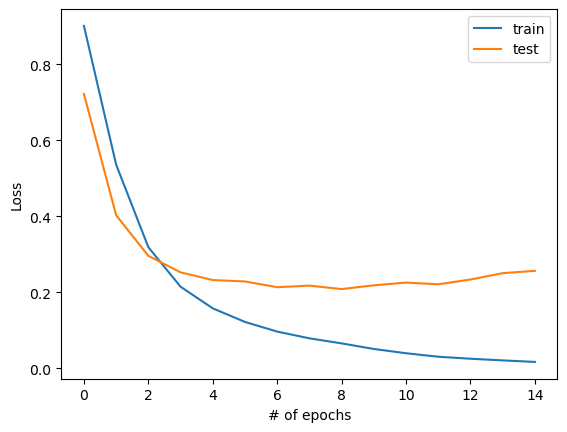

In [48]:
# plot history
plt.plot(history.history['loss'], label= 'train')
plt.plot(history.history['val_loss'], label= 'test')
plt.legend()
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.show();

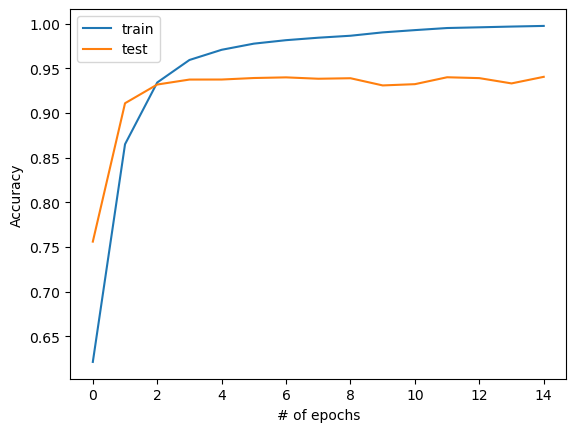

In [49]:
# plot history
plt.plot(history.history['accuracy'], label= 'train')
plt.plot(history.history['val_accuracy'], label= 'test')
plt.legend()
plt.xlabel('# of epochs')
plt.ylabel('Accuracy')
plt.show();

### Evaluate the model

In [50]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 94.05%


In [51]:

# Predict sentiment labels
predicted_labels = model.predict(padded_sequences)



3883/3883 [==============================] - 42s 10ms/step


In [52]:
predicted_labels

array([[0.99309134, 0.00377028, 0.00313842],
       [0.00136719, 0.9937552 , 0.00487752],
       [0.00136693, 0.99375856, 0.00487448],
       ...,
       [0.0018416 , 0.00317701, 0.99498147],
       [0.9931403 , 0.0037384 , 0.00312126],
       [0.00184036, 0.00317381, 0.9949858 ]], dtype=float32)

In [53]:
predicted_labels_df= pd.DataFrame(predicted_labels)

In [54]:
predicted_labels_df

,0,1,2
0,0.993091,0.003770,0.003138
1,0.001367,0.993755,0.004878
2,0.001367,0.993759,0.004874
3,0.001926,0.003326,0.994747
4,0.992291,0.004253,0.003456
...,...,...,...
124239,0.001840,0.003174,0.994986
124240,0.001842,0.003177,0.994981
124241,0.001842,0.003177,0.994981
124242,0.993140,0.003738,0.003121


In [55]:
predicted_labels_df.index

RangeIndex(start=0, stop=124244, step=1)

In [56]:
max_prob = predicted_labels_df.idxmax(axis=1)
    

In [57]:
max_prob= pd.DataFrame(max_prob, columns=['predicted_label'])

In [58]:
df_labled= df.merge(max_prob, left_index=True, right_index=True)

In [59]:
df_labled.head()

,date,adj_close,volume,ticker,1_day_return,processed_text,labels,predicted_label
0,2017-01-31,28.308922,196804000,AAPL,-0.002307,apple break losing streak quarter pro nehal ch...,negative,0
1,2017-01-31,28.308922,196804000,AAPL,-0.002307,apple ipad air gb wifi space gray latest model,neutral,1
2,2017-01-31,28.308922,196804000,AAPL,-0.002307,alien project apple music spotify tidal etc pe...,neutral,1
3,2017-01-31,28.308922,196804000,AAPL,-0.002307,apple iphone gb black unlocked smartphone case...,positive,2
4,2017-01-31,28.308922,196804000,AAPL,-0.002307,finally stream prince music spotify apple musi...,negative,0


In [60]:
df_labled.drop(columns=['labels', 'processed_text'], inplace=True)

In [61]:
# Save the updated DataFrame
df_labled.to_csv('../Data/sentiment_labels.csv', index=False)  